In [56]:
import os
from gymnasium import Env
from gymnasium import spaces
from gymnasium.spaces import Discrete
import pandas as pd
import numpy as np

from stable_baselines3 import DQN
from stable_baselines3 import PPO
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy



In [57]:
carbon_intensity = pd.read_csv('Datasets/Carbon_intensity_processed_hourly.csv')
electricity_usage = pd.read_csv('Datasets/Household_processed_hourly.csv')

In [58]:
carbon_intensity['Datetime (UTC)'] = pd.to_datetime(carbon_intensity['Datetime (UTC)'], utc=True)
carbon_intensity = carbon_intensity.set_index('Datetime (UTC)')
carbon_intensity.index = carbon_intensity.index.tz_convert(None)
carbon_intensity = carbon_intensity['Carbon Intensity gCO₂eq/kWh (LCA)']


In [59]:
c_int = np.asarray(carbon_intensity['2021-07-05 00:00:00':'2021-12-05 21:00:00'],dtype=int)

In [60]:
electricity_usage['date'] = pd.to_datetime(electricity_usage['date'], utc=True)
electricity_usage= electricity_usage.set_index('date')
electricity_usage.index = electricity_usage.index.tz_convert(None)
electricity_usage = electricity_usage['energy meter val']

In [61]:
e_usage = np.asarray([(i * 10) for i in electricity_usage['2015-07-05 00:00:00':]], dtype=int)

----------------------

In [62]:
evaluation_data = pd.DataFrame()
hourly_emission_difference = []
hourly_battery_level = []
hourly_baseline_em = []
hourly_battery_em = []
decision_hist = []
reward_hist = []
total_emissions_saved = 0


In [63]:
# Constant Environment Vars 
env_length = 1000 # number of hours
battery_size = 1000 #Watt/Hour
charge_discharge_rate = 250 #Watt/Hour

In [64]:
def get_carbon_emissions(c_int, e_usage):
    em = c_int * (e_usage/1000)
    return em

In [65]:
def reward_algo(self):
    curr_delta = self.emissions_baseline - self.emissions_with_battery
    if curr_delta > self.state["old_em_delta"]:
        reward_hist.append(1)
        return 1
    else:
        reward_hist.append(-1)
        return -1

In [66]:
def is_done(self):
    if self.length == 0:
        return True
    else:
        return False

In [67]:
class Environment(Env):
    def __init__(self):
        super().__init__()
        # Actions are discharge(-1), nothing (0) and charge (1)
        self.action_space = Discrete(3)
        self.observation_space = spaces.Dict({
                "carbon_int" : spaces.Box(low = 0, high = 100000, shape=(1,), dtype=int),
                "electric_usage" : spaces.Box(low = 0, high = 10000, shape=(1,), dtype=int),
                "battery_charge" : spaces.Box(low = 0, high = battery_size, shape=(1,), dtype=int),
                "old_em_delta" : spaces.Box(low = -np.inf, high = np.inf, shape=(1,), dtype=int)
            }
        )            
        
        self.c_int = c_int
        self.e_usage = e_usage
        self.length = env_length
        self.hour_index = 0
        self.emissions_baseline = 0
        self.emissions_with_battery = 0
        
        self.state = {
            "carbon_int": np.array([self.c_int[0]]),
            "electric_usage": np.array([self.e_usage[0]]),
            "battery_charge": np.array([0]),
            "old_em_delta": np.array([0]),
        }
        
    def step(self, action):

        if self.state["old_em_delta"] != [0]:
          self.state.update({"old_em_delta" : self.emissions_baseline - self.emissions_with_battery})

        curr_c_int = self.state["carbon_int"]
        curr_e_usage = self.state["electric_usage"]
        curr_charge = self.state["battery_charge"]
        
        baseline_em_now = get_carbon_emissions(curr_c_int, curr_e_usage)
        self.emissions_baseline = self.emissions_baseline + baseline_em_now
        hourly_baseline_em.append(baseline_em_now)
        

        # Perform 'game logic' for each possible agent action
        if action == 0 and curr_charge >= 0:
            decision_hist.append("Discharged")
            if curr_charge > charge_discharge_rate:
                em_new = get_carbon_emissions(curr_c_int, curr_e_usage - charge_discharge_rate)
                hourly_battery_em.append(em_new)
                self.emissions_with_battery = self.emissions_with_battery + em_new
                new_battery_charge_val = curr_charge - charge_discharge_rate
                hourly_battery_level.append(new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
            elif 0 <= curr_charge <= charge_discharge_rate:
                em_new = get_carbon_emissions(curr_c_int, curr_e_usage - curr_charge)
                hourly_battery_em.append(em_new)
                self.emissions_with_battery = self.emissions_with_battery + em_new
                new_battery_charge_val = np.array([0])
                hourly_battery_level.append(new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
            
        elif action == 1:
            decision_hist.append("Nothing")
            hourly_battery_level.append(curr_charge)
            em_new = get_carbon_emissions(curr_c_int,curr_e_usage)
            hourly_battery_em.append(em_new)
            self.emissions_with_battery = self.emissions_with_battery + em_new
            
        elif action == 2 and curr_charge <= battery_size:
            decision_hist.append("Charged")
            if (battery_size - charge_discharge_rate) <= curr_charge <= battery_size:
                em_new = get_carbon_emissions(curr_c_int, curr_e_usage + (battery_size - curr_charge))
                hourly_battery_em.append(em_new)
                self.emissions_with_battery = self.emissions_with_battery + em_new
                new_battery_charge_val = np.array([battery_size])
                hourly_battery_level.append(new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
            elif 0 <= curr_charge < (battery_size - charge_discharge_rate):
                em_new = get_carbon_emissions(curr_c_int, curr_e_usage + charge_discharge_rate)
                hourly_battery_em.append(em_new)
                self.emissions_with_battery = self.emissions_with_battery + em_new
                new_battery_charge_val = curr_charge + charge_discharge_rate
                hourly_battery_level.append(new_battery_charge_val)
                self.state.update({"battery_charge" : new_battery_charge_val})
        else:
            decision_hist.append("PASSED")
            print("Smth weird happened")
            pass
        
        
        hourly_emission_difference.append(self.emissions_baseline-self.emissions_with_battery)
        
        # Update env variables
        self.length = self.length - 1
        self.hour_index = self.hour_index + 1
        # Go to next state
        self.state.update({"carbon_int": np.array([self.c_int[self.hour_index]])})
        self.state.update({"electric_usage": np.array([self.e_usage[self.hour_index]])})

        # Update reward
        reward = reward_algo(self)
            
        # Check if finished
        done = is_done(self)
        
        info = {}
        truncated = False
        return self.state, reward, done, truncated, info
    
    
    def reset(self, seed = None, options = None):
        self.state = {
            "carbon_int": np.array([self.c_int[0]]),
            "electric_usage": np.array([self.e_usage[0]]),
            "battery_charge": np.array([0]),
            "old_em_delta" : np.array([0]),
        } 
        self.c_int = c_int
        self.e_usage = e_usage
        self.length = env_length
        self.hour_index = 0
        self.emissions_baseline = 0
        self.emissions_with_battery = 0

        info = {}
        
        return self.state, info

In [68]:
env = Environment()

In [69]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

In [70]:
# episodes = 5
# for episode in range(1, episodes+1):
#     state = env.reset()
#     done = False
#     score = 0
# 
#     while not done:
#         action = env.action_space.sample() # Random actions here
#         n_state, reward, done, truncated, info = env.step(action)
#         score+=reward
#     print('Episode:{} Score:{}'.format(episode, score))

In [71]:
log_path = os.path.join('Training', 'Logs')
# vec_env = make_vec_env(env, n_envs=4)
model = PPO("MultiInputPolicy", env, verbose=1, tensorboard_log = log_path)
# model = DQN('MultiInputPolicy', env, verbose = 1, tensorboard_log = log_path)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [72]:
model.learn(total_timesteps=60000)

Logging to Training/Logs/PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1e+03    |
|    ep_rew_mean     | -223     |
| time/              |          |
|    fps             | 297      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 1e+03       |
|    ep_rew_mean          | -194        |
| time/                   |             |
|    fps                  | 249         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.011354081 |
|    clip_fraction        | 0.105       |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | -0.0023     |

In [73]:
evaluate_policy(model, env, n_eval_episodes=10, render = False)

/home/doga/miniconda3/envs/myenv/lib/python3.9/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(-1000.0, 0.0)

In [82]:
episodes = 1
for episode in range(1, episodes+1):
    obs, inf = env.reset()
    evaluation_data = pd.DataFrame(None)
    hourly_emission_difference.clear()
    hourly_battery_level.clear()
    hourly_baseline_em.clear()
    hourly_battery_em.clear()
    decision_hist.clear()
    reward_hist.clear()
    done = False
    score = 0

    while not done:
        action, _ = model.predict(obs) # Random actions here
        obs, reward, done, truncated, info = env.step(action)
        score += reward
    print('Episode:{} Reward:{}'.format(episode, score))
    
    evaluation_data.insert(0,column="energy_usage",value=pd.Series(e_usage[:env_length]))
    evaluation_data.insert(1,column="carbon_intensity",value=pd.Series(c_int[:env_length]))
    evaluation_data.insert(2,column="battery_level",value=pd.Series(hourly_battery_level))
    evaluation_data.insert(3,column="decision",value=pd.Series(decision_hist))
    evaluation_data.insert(4,column="emission_baseline",value=pd.Series(hourly_baseline_em))
    evaluation_data.insert(5,column="emission_w_battery",value=pd.Series(hourly_battery_em))
    evaluation_data.insert(6,column="emission_delta",value=pd.Series(hourly_emission_difference))
    evaluation_data.insert(7,column="reward",value=pd.Series(reward_hist))

Episode:1 Reward:-616


In [83]:
evaluation_data.to_csv("evaluation.csv")

In [84]:
print(evaluation_data)

     energy_usage  carbon_intensity battery_level    decision  \
0             969               404           [0]  Discharged   
1            1583               370           [0]  Discharged   
2             818               388           [0]  Discharged   
3            1201               399           [0]  Discharged   
4            1369               402           [0]  Discharged   
..            ...               ...           ...         ...   
995          1007               204           [0]  Discharged   
996           748               201           [0]  Discharged   
997           779               200           [0]  Discharged   
998           934               205           [0]  Discharged   
999          1055               222           [0]  Discharged   

        emission_baseline    emission_w_battery emission_delta  reward  
0               [391.476]             [391.476]          [0.0]      -1  
1                [585.71]              [585.71]          [0.0]      -1  


In [85]:
# training_log_path = os.path.join(log_path, 'DQN_9')

-3695.0


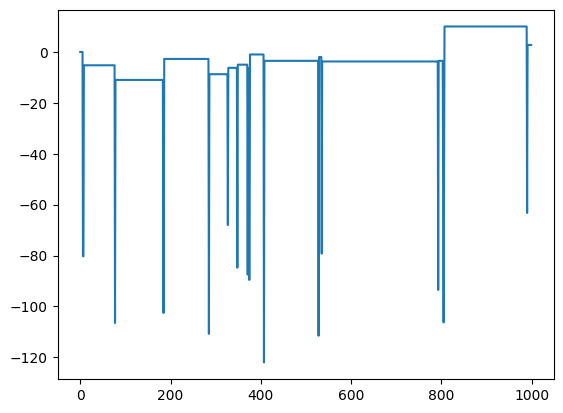

In [86]:
my_list = map(lambda x: x[0], evaluation_data["emission_delta"])
ser = pd.Series(my_list)
ser.plot()
print(ser.sum())

<Axes: >

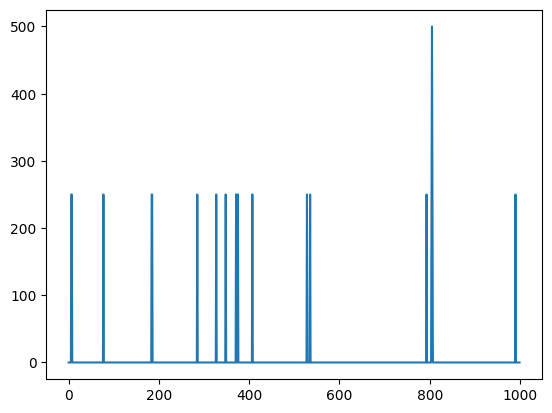

In [87]:
my_list = map(lambda x: x[0], evaluation_data["battery_level"])
ser = pd.Series(my_list)
ser.plot()